In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding


In [60]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Jeffs
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jeffs
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [33]:
#wordcloud stopwords
stopword = set(STOPWORDS)
stopword.add('')

#nltk stopwords
stop_words = set(stopwords.words('english'))

In [34]:
def bagoword(lst):
    cnt = Counter()
    for word in lst:
        cnt[word]+=1
    return cnt

def bagoword_corpus(lst, stopwords):
    cnt = Counter()
    for r in lst:
        for word in wordlist(r):
            if word not in stopwords:
                cnt[word]+=1
    return cnt


def wordlist(review):
    #Convert a review into a list of words(strings).
    lines = review.split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip().lower(), lines)
    return list(words)

In [35]:
df = pd.read_csv('../train.csv')
df.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


In [37]:
# Feature Engineering

df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length_nonstopwords'] = df['review'].apply(lambda x: len([word for word in (re.sub(r'[^\w]', ' ', x)).lower().split() if word not in stopword]))

## Data Notes

- 1 = fake review | 0 = genuine review
- 25819 Fake Reviews, 225005 Genuine (250824 total)
    - might require downsampling to balance label distribution
- Mostly 4 & 5 Star Reviews
- some words are very common in both genuine and fake
- 

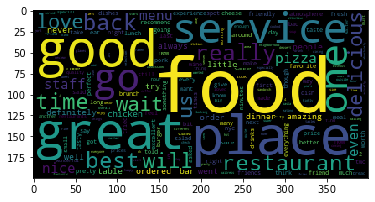

In [38]:
# Fake Review Bag Of Words & WordCloud
bow_fake = bagoword_corpus(df[df['label']==1]['review'], stopword)
bow_fake_sort = sorted(bow_fake.items(), key=lambda x: x[1], reverse=True)
wc_fake = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_fake)
plt.imshow(wc_fake) 

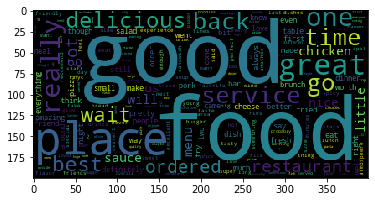

In [39]:
# Genuine Review Bag Of Words & WordCloud
bow_real = bagoword_corpus(df[df['label']==0]['review'], stopword)
bow_real_sort = sorted(bow_real.items(), key=lambda x: x[1], reverse=True)
wc_real = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_real)
plt.imshow(wc_real) 

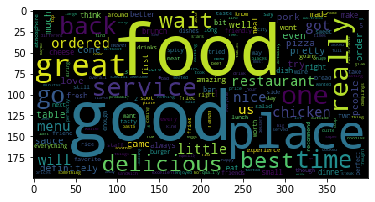

In [40]:
bow_corpus = bagoword_corpus(df['review'], stopword)
wc = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_corpus)
plt.imshow(wc) 

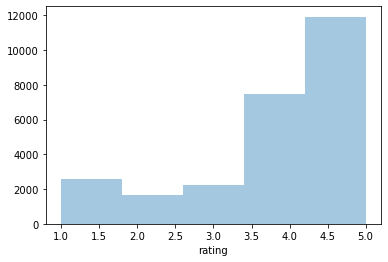

In [41]:
sns.distplot(df[df['label']==1]['rating'], kde=False, bins=5)

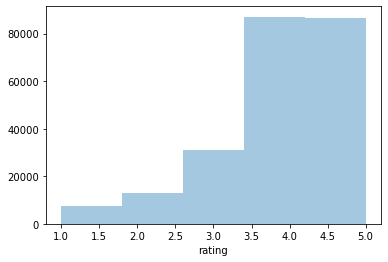

In [42]:
sns.distplot(df[df['label']==0]['rating'], kde=False, bins=5)

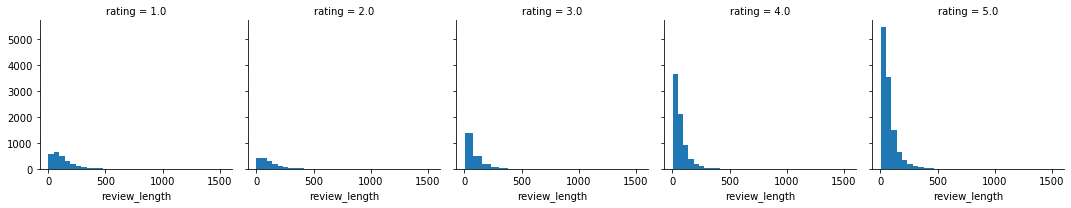

In [43]:
g = sns.FacetGrid(data=df[df['label']==1], col='rating')
g.map(plt.hist, 'review_length', bins=20)

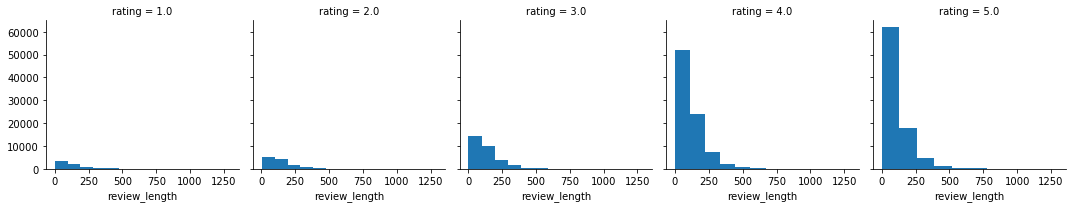

In [44]:
g = sns.FacetGrid(data=df[df['label']==0], col='rating')
g.map(plt.hist, 'review_length', bins=10)

### Build Custom Corpus

- lowercase
- symbol removal with regex
- stopword removal (r_)

In [45]:
rev_lst = []
token_lst = []
for index, row in df['review'].iteritems():
    r = (re.sub(r'[^\w]', ' ', row)).lower()
    r_ = [word for word in r.split() if word not in stopword]
    rev_lst.append(r)
    token_lst.append(r_)

In [46]:
cv = text.CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,2))
X = cv.fit_transform(rev_lst)

In [47]:
print(len(cv.get_feature_names()))

4106048


In [48]:
tfid = text.TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,2))
Y = tfid.fit_transform(rev_lst)

In [50]:
print(len(tfid.get_feature_names()))

4106048


### Representation Notes

- might want to include max_df parameter as a corpus-specific stop condition (check score of noticable words from wordclouds)
- uni + bigrams with word analyzer yields ALOT of features

### Word2Vec

- also doc2vec should be investigated
- https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456 for article code is pulled from 

In [57]:
# Word2Vec By NN

EMBEDDING_DIM = 100

tokenizer_obj = Tokenizer()
total_reviews = df['review'].values
tokenizer_obj.fit_on_texts(total_reviews)
max_length = max([len(s.split()) for s in total_reviews])
vocab_size =len(tokenizer_obj.word_index) + 1
X_train_tokens = tokenizer_obj.texts_to_sequences(total_reviews)


In [58]:
model_nn = Sequential()

# Word2Vec created in Embedding***
model_nn.add(Embedding(vocab_size, EMBEDDING_DIM,input_length=max_length))

model_nn.add(GRU(units=32, dropout=.2, recurrent_dropout=.2))
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# Word2Vec explicit with gensim

review_lines = list()
lines = df['review'].values.tolist()
stop_words = set(stopwords.words('english'))
    
for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

In [64]:
model = Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=4, workers=4, min_count=1)
words = list(model.wv.vocab)
print(len(words))

153473
